## Relevant Analytic Expressions

$$L_t(t) = \frac{e^{-4 \left(1-\sqrt{\lambda}\right)^2 \eta_0 t}}{16 \sqrt{\pi } \lambda^{3/4} \eta_0^{3/2} t^{3/2}}$$

$$L_g(t) = \frac{2 \sqrt{\left(\sqrt{\lambda}-1\right)^2 \eta_0 t} \Gamma \left(\frac{1}{2},4 \left(\sqrt{\lambda}-1\right)^2 \eta_0 t\right)-e^{-4 \left(\sqrt{\lambda}-1\right)^2 \eta_0 t}}{2 \sqrt{\pi } \lambda^{3/4} \sqrt{\eta_0} \sqrt{t}}$$

In [1]:
import numpy as np
import scipy
from scipy.special import gamma, gammaincc, erf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import os
from scipy.optimize import curve_fit

In [2]:
matplotlib.set_loglevel('ERROR')

## Defining Relevant Analytic Expressions

Below we define the relevant analytic expressions provided in Levi's paper.

In [3]:
# Checked
def custom_gamma(a,x):
    # Unregularised incomplete gamma function (definition in Wolfram)
    return gamma(a) * gammaincc(a,x)

# Checked
def L_t(lambda_var, n0, t):
    return np.exp(-4 * (1 - np.sqrt(lambda_var))**2 * n0 * t) / (16 * lambda_var**(3/4) * n0**(3/2) * np.sqrt(np.pi) * t**(3/2))

# Checked
def L_g(lambda_var, n0, t):
    numerator = (-np.exp(-4*((-1 + np.sqrt(lambda_var))**2)*n0*t) + 
                 2*np.sqrt((-1 + np.sqrt(lambda_var))**2*n0*t)*custom_gamma(1/2, 4*(-1 + np.sqrt(lambda_var))**2*n0*t))
    
    denominator = 2*(lambda_var**(3/4))*np.sqrt(n0)*np.sqrt(np.pi)*np.sqrt(t)
    result = numerator / denominator
    return (-1) * result

# Checked
def A(lambda_var, epsilon, n0, t):
    argument = np.sqrt(epsilon/(2 * L_t(lambda_var, n0, t)))

    return erf(argument)

# Checked
def B(lambda_var, epsilon, n0, t):
    argument = np.sqrt(epsilon/(2 * L_g(lambda_var, n0, t)))

    return erf(argument)

## Fitting Function

We use the following function to fit the linear estimators data.

In [4]:
def error_function_model(x, a, b):
    c = 1/2
    d = 0.5
    return c*erf(a*(x - b)) + d

## Calculating Sharpness Measures

Below is the script which generates the relevant plots for the linear estimator setting in the workshop paper. One can change the boolean log-log to generate the log-log plots.

In [14]:
log_log = False

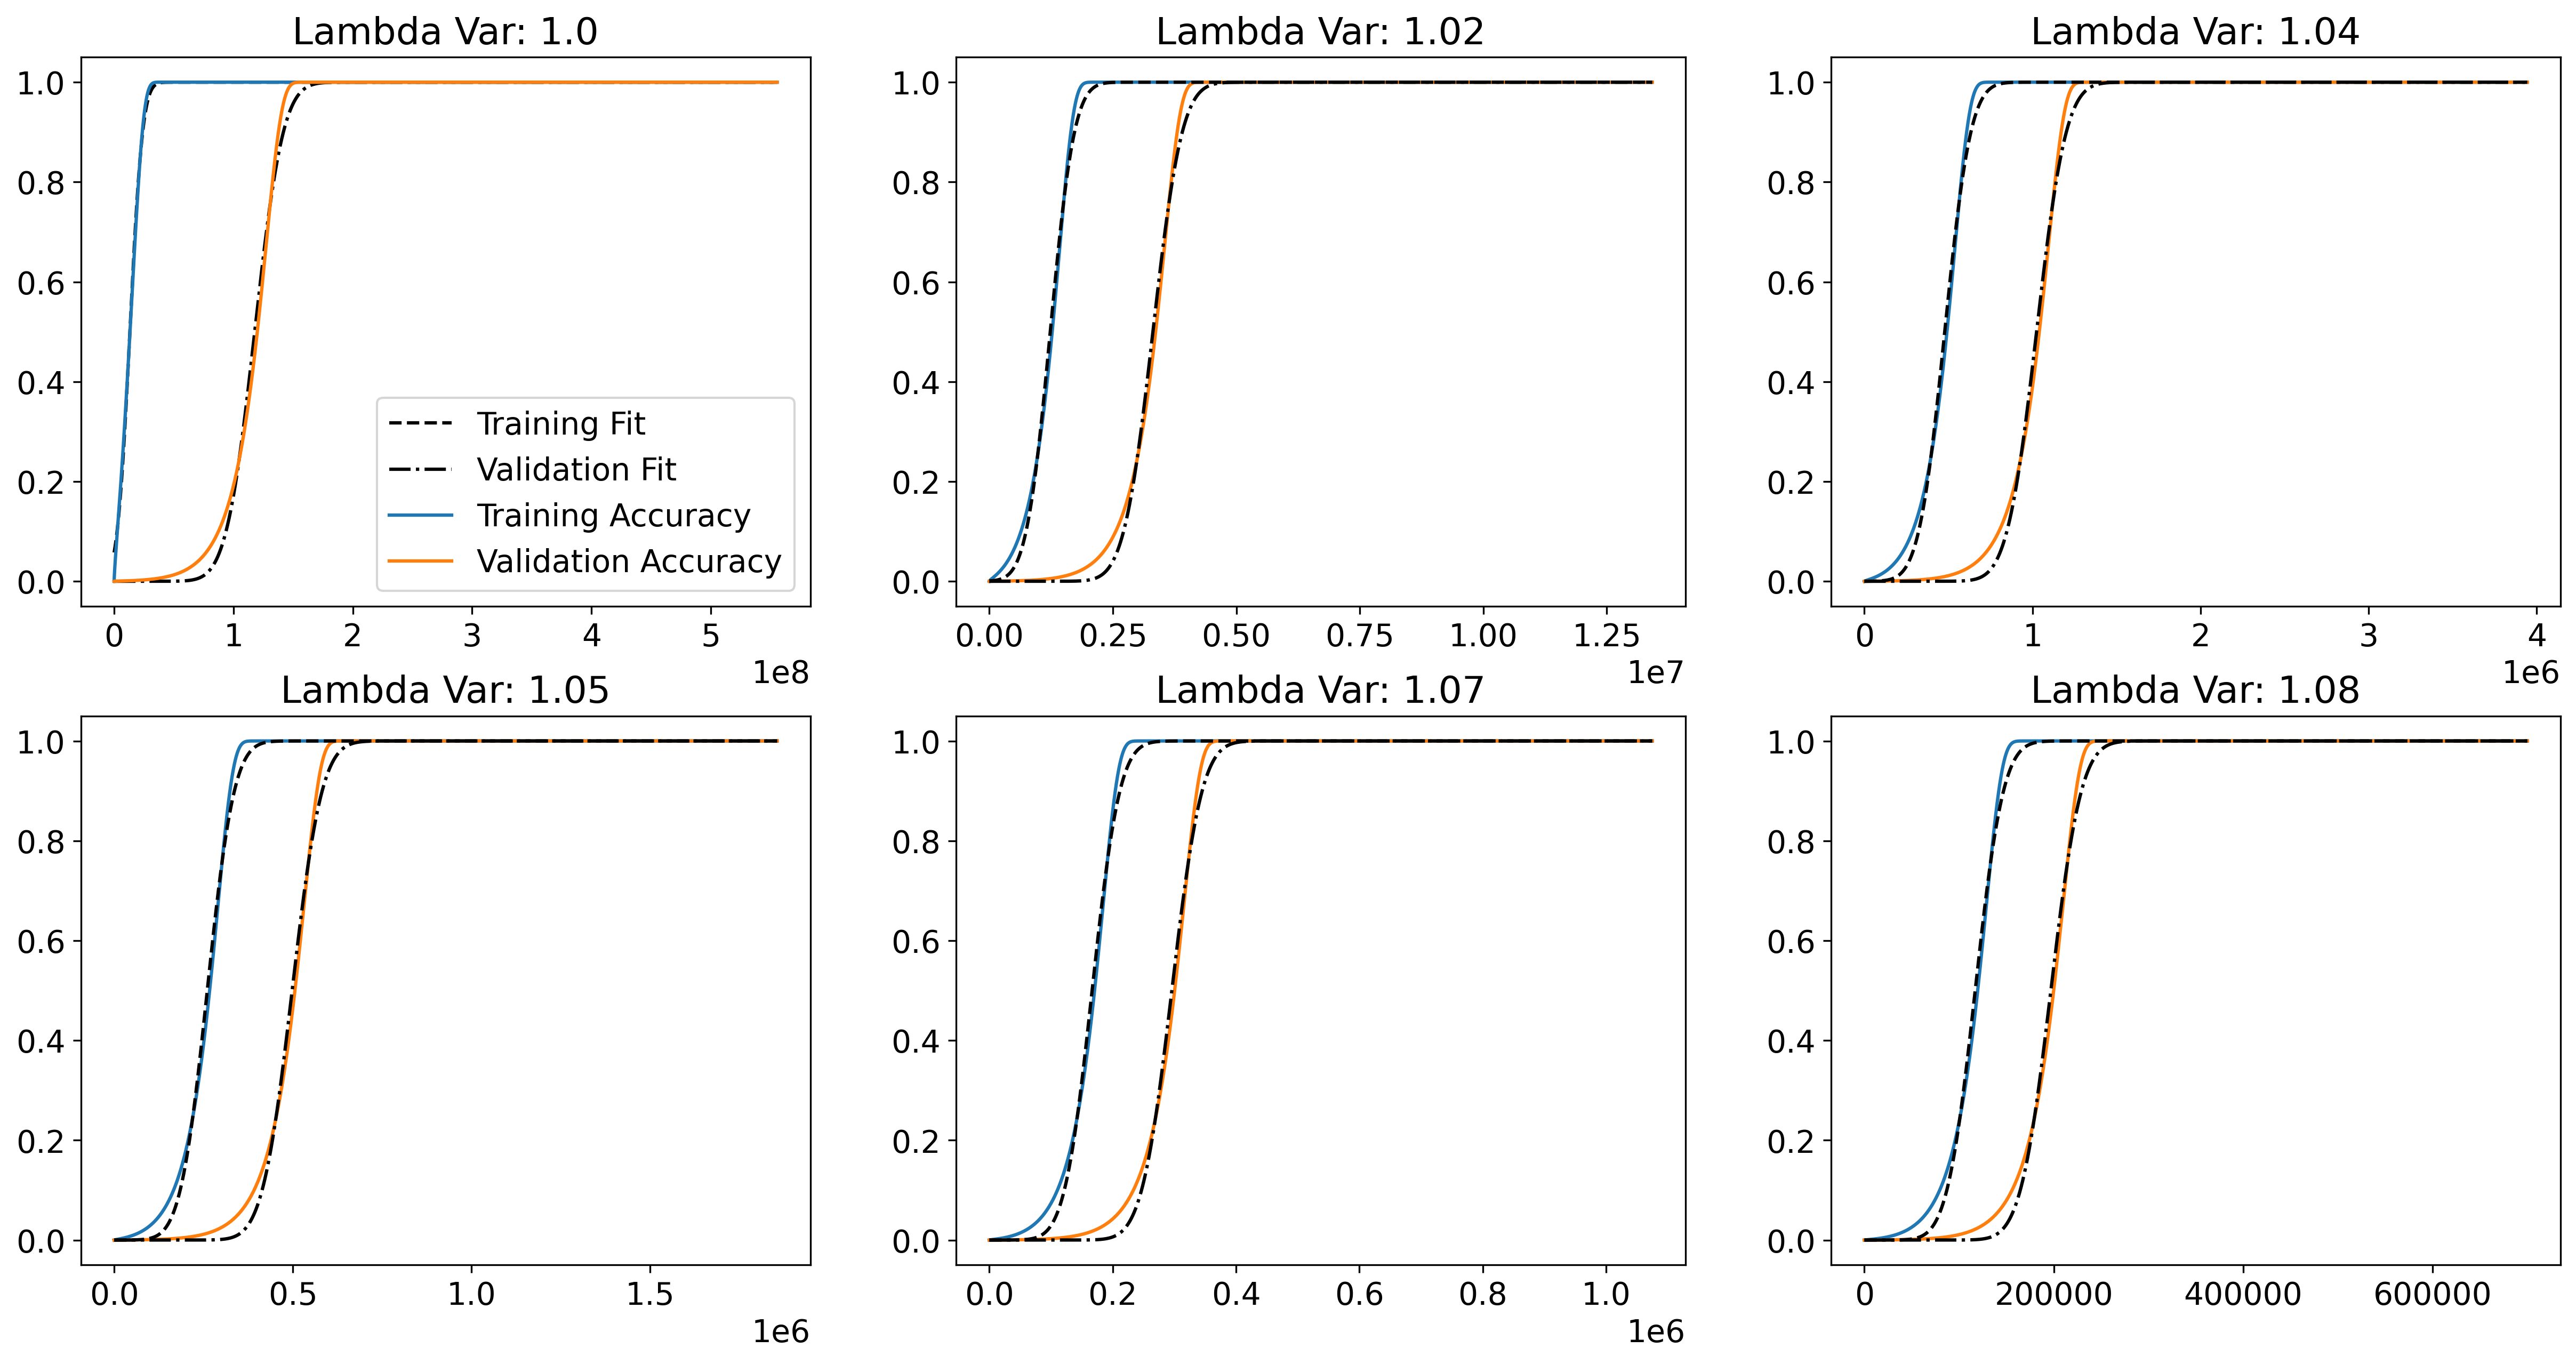

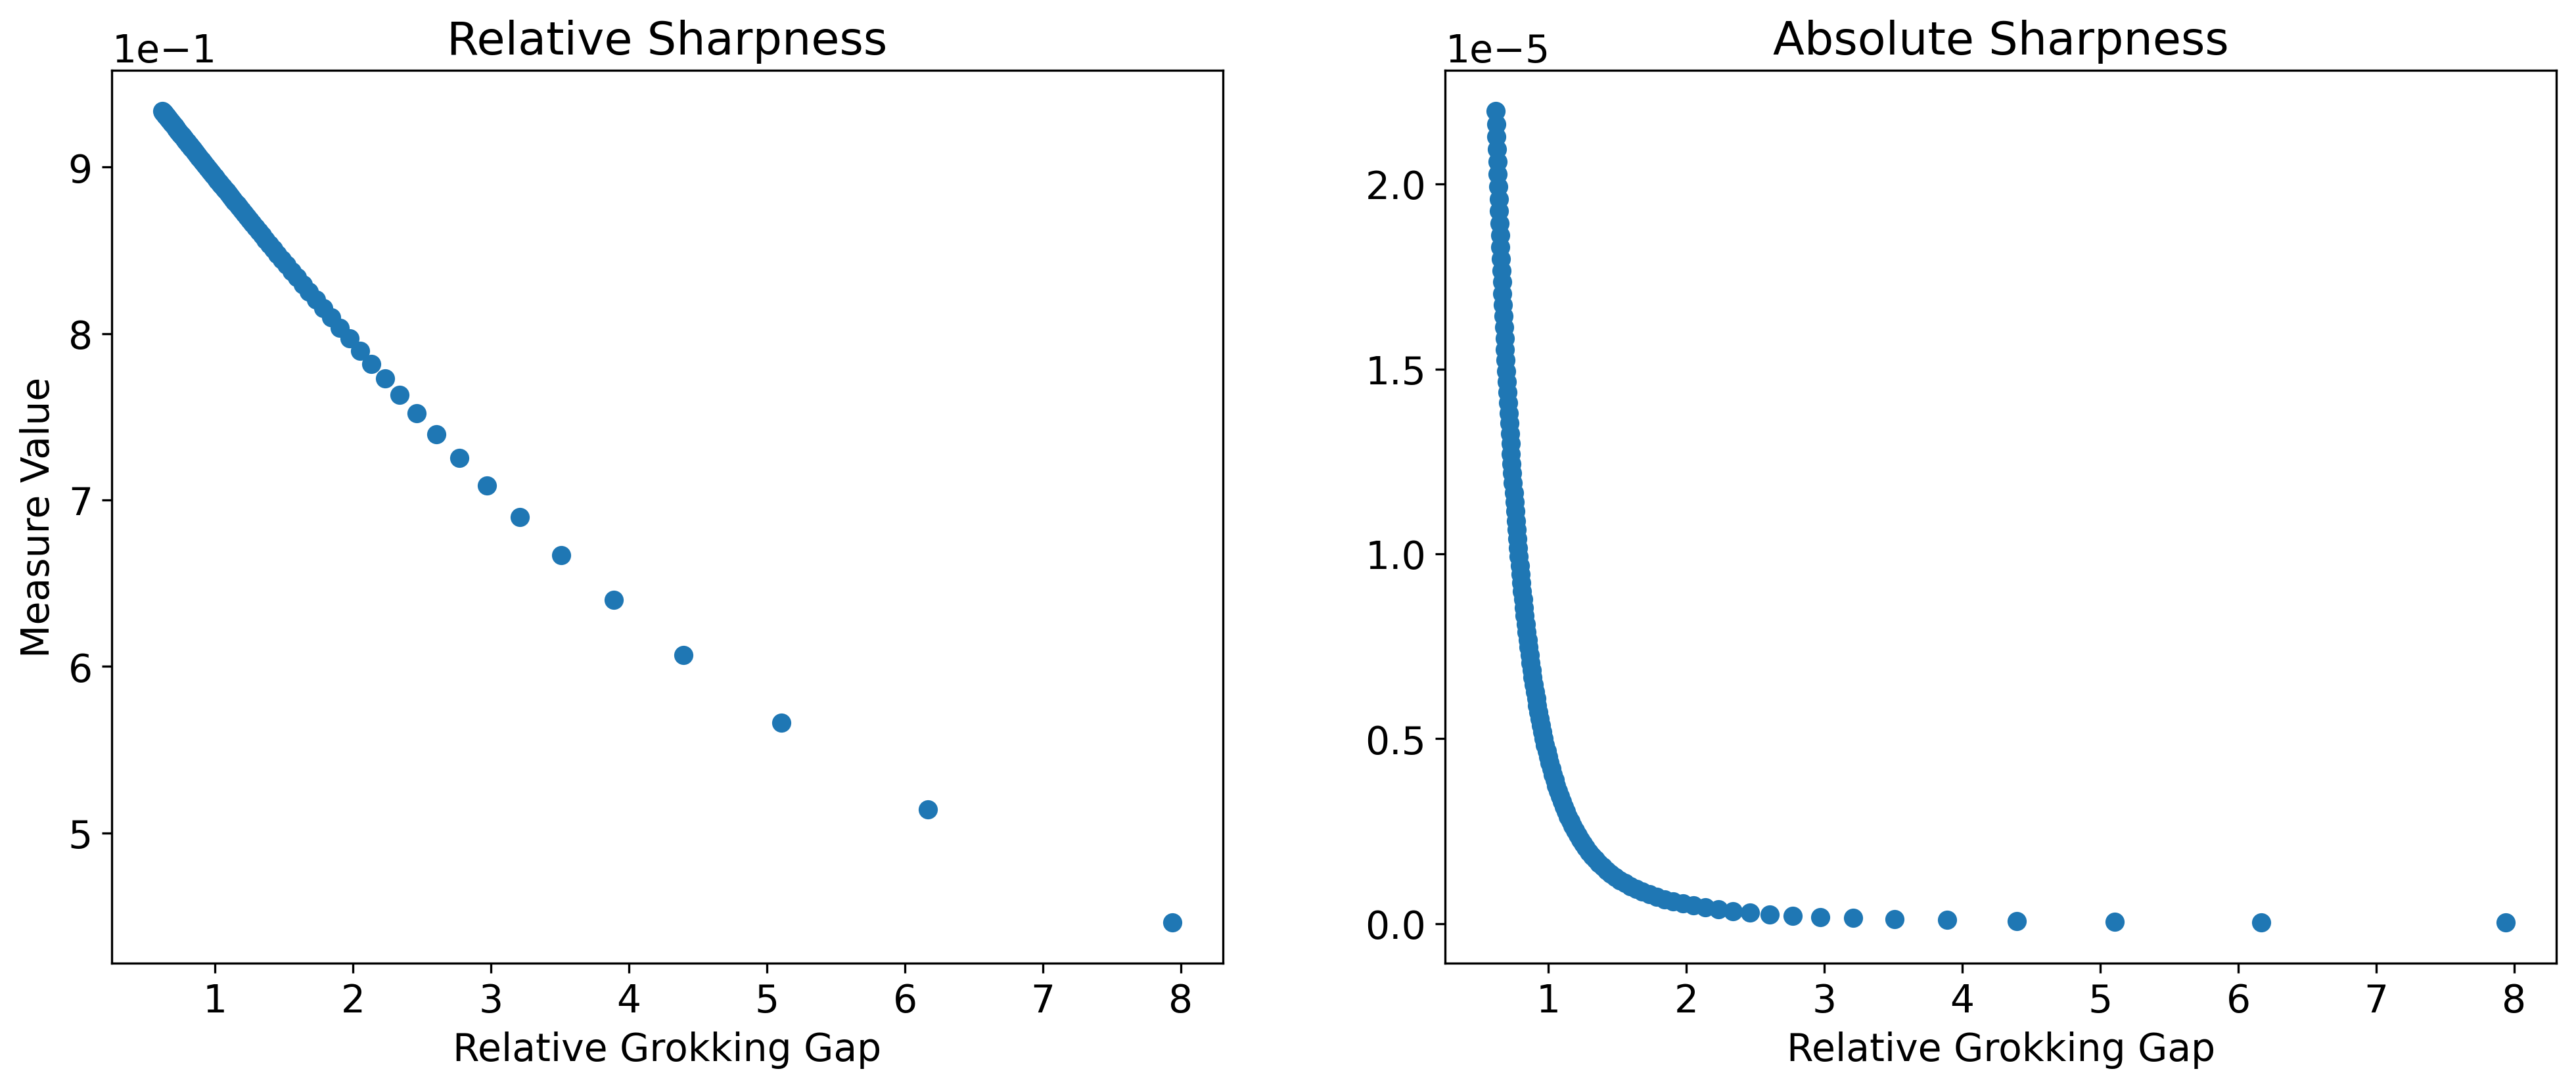

In [16]:
epsilon = 1e-10
n0 = 0.01

n_points = 120

# Original range
start, end = 1.003, 1.1

skewed_linear_space = np.linspace(0, 1, n_points)**2  # Squaring to skew towards start

# Apply transformation and scaling
lambda_values = np.sqrt(skewed_linear_space) * (end - start) + start

# Relative grokking gap for each lambda value
relative_grokking_gaps = np.zeros_like(lambda_values)

select_As = []
select_Bs = []
lambda_vars_selected = []
max_sharpnesses_erf = []
relative_sharpnesses_erf = []
relative_grokking_gap_erf = []
training_fits = []
validation_fits = []
select_ts = []
select_training_fits = []
select_validation_fits = []

for i, lambda_var in enumerate(lambda_values):
    
    max_value = 5e3/((lambda_var-1)**2)
    t = np.linspace(1, max_value, 50000)

    training_accuracy = A(lambda_var, epsilon, n0, t)
    validation_accuracy = B(lambda_var, epsilon, n0, t)

    # Find where the training accuracy reaches close to 1 then cut the t array to addition max_value /

    try:
        popt_training, pcov_training = curve_fit(error_function_model, t, training_accuracy, maxfev=1000, p0=[1/max_value, max_value/5])
        popt_validation, pcov_validation = curve_fit(error_function_model, t, validation_accuracy, maxfev=1000, p0=[1/max_value, max_value/5])
    except:
        print(f"Failed to fit error function model for input size {lambda_var}.")
        continue

    if i % (n_points//6) == 0:
        select_As.append(training_accuracy)
        select_Bs.append(validation_accuracy)
        lambda_vars_selected.append(lambda_var)
        select_ts.append(t)
        select_training_fits.append(popt_training)
        select_validation_fits.append(popt_validation)

    erf_relative_grokking_gap = popt_validation[1] / popt_training[1] - 1
    max_deriv_validation_accuracy_with_erf = popt_validation[0] / (np.sqrt(np.pi))
    relative_deriv_with_erf = popt_validation[0] / popt_training[0]

    relative_grokking_gaps[i] = erf_relative_grokking_gap
    relative_sharpnesses_erf.append(relative_deriv_with_erf)
    max_sharpnesses_erf.append(max_deriv_validation_accuracy_with_erf)
    relative_grokking_gap_erf.append(erf_relative_grokking_gap)
    training_fits.append(popt_training)
    validation_fits.append(popt_validation)

font = {
        "family": "normal",
        "size": 14,
    }

plt.rc("font", **font)

fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=300)

for i in range(6):

    if i == 0:
        ax[i//3, i%3].plot(select_ts[i], error_function_model(select_ts[i], *select_training_fits[i]), color="black", linestyle="--", label=f"Training Fit")
        ax[i//3, i%3].plot(select_ts[i], error_function_model(select_ts[i], *select_validation_fits[i]), color="black", linestyle="dashdot", label=f"Validation Fit")

        ax[i//3, i%3].plot(select_ts[i], select_As[i], label=f"Training Accuracy")
        ax[i//3, i%3].plot(select_ts[i], select_Bs[i], label=f"Validation Accuracy")

        ax[i//3, i%3].legend()
    else:
        ax[i//3, i%3].plot(select_ts[i], select_As[i])
        ax[i//3, i%3].plot(select_ts[i], select_Bs[i])

        ax[i//3, i%3].plot(select_ts[i], error_function_model(select_ts[i], *select_training_fits[i]), color="black", linestyle="--")
        ax[i//3, i%3].plot(select_ts[i], error_function_model(select_ts[i], *select_validation_fits[i]), color="black", linestyle="dashdot")

    ax[i//3, i%3].set_title(f"Lambda Var: {round(lambda_vars_selected[i], 2)}")
    
plt.savefig("figures/lambda_var_fits.pdf", bbox_inches="tight")

if log_log:
    # Create subplot with two side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=300)
else:
    # Create subplot with two side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Set tick label format to be scientific notation
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

log_erf_relative_grokking_gaps = np.log(relative_grokking_gaps)
log_relative_sharpnesses_erf = np.log(relative_sharpnesses_erf)

# Linear regression on transformed data
slope, intercept = np.polyfit(log_erf_relative_grokking_gaps, log_relative_sharpnesses_erf, 1)

trend_line = np.exp(intercept) * np.array(relative_grokking_gaps)**slope

if log_log:
    ax1.plot(relative_grokking_gaps, trend_line, color='black', label=f"Regression: exp({intercept:.2f}) * x^{slope:.2f}")

ax1.scatter(relative_grokking_gaps, relative_sharpnesses_erf)

ax1.set_title("Relative Sharpness")
ax1.set_xlabel("Relative Grokking Gap")
ax1.set_ylabel("Measure Value")

if log_log:
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.legend()

log_max_deriv_with_erf_list = np.log(max_sharpnesses_erf)

# Linear regression on transformed data
slope, intercept = np.polyfit(log_erf_relative_grokking_gaps, log_max_deriv_with_erf_list, 1)

trend_line = np.exp(intercept) * np.array(relative_grokking_gaps)**slope

if log_log:
    ax2.plot(relative_grokking_gaps, trend_line, color='black', label=f"Regression: exp({intercept:.2f}) * x^{slope:.2f}")

ax2.set_title("Absolute Sharpness")
ax2.set_xlabel("Relative Grokking Gap")
ax2.scatter(relative_grokking_gaps, max_sharpnesses_erf)

if log_log:
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.legend()

if log_log:
    plt.savefig("figures/lambda_var_analysis_log_log.pdf", bbox_inches="tight")
else:
    plt.savefig("figures/lambda_var_analysis.pdf", bbox_inches="tight")